In [1]:
import numpy as np
import torch
from src import kernel_flow, datagen
#import datagen

# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data[0::2]
train_data = Data[:600,:].T
test_data = Data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data(test_data,delay,normalize)


model = kernel_flow.KernelFlows("anl3",nparameters= nparameters, regu_lambda=regu_lambda)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())

for i in range(1000):
    optimizer.zero_grad()
    rho = model.forward()
    if rho>=0 and rho<=1:
        rho.backward()
        optimizer.step()
        print(rho)

print(model.kernel_params)

tensor(0.8111, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0945, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0286, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0351, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0146, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0407, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0099, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0447, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0417, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2596, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1701, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0192, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0530, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0252, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0656, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0166, dtype=tor

tensor(0.0699, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0968, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1234, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0668, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0709, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0945, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0626, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2675, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0749, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0785, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0733, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0343, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2357, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0733, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0640, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0691, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0252, dtype=tor

tensor(0.0153, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0184, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0179, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0251, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0084, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0131, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0257, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0237, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0268, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0225, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0134, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0325, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0289, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0105, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0149, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0141, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0202, dtype=tor

tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0060, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0115, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0126, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0058, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=tor

tensor(0.0123, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=tor

tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0051, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=tor

tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0094, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0060, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=tor

In [6]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
Y_pred = model.predict(torch.Tensor(X_test).double())

In [7]:
Y_pred

tensor([[ 0.3845, -0.1843],
        [ 0.3388,  0.1153],
        [ 0.6973,  0.1017],
        ...,
        [ 0.9685, -0.0066],
        [-0.8903,  0.2906],
        [-0.3344, -0.2671]], dtype=torch.float64, grad_fn=<MmBackward>)

In [8]:
(Y_pred.detach()-Y_test).pow(2).mean()

tensor(7.2831e-11, dtype=torch.float64)

Text(0, 0.5, 'y')

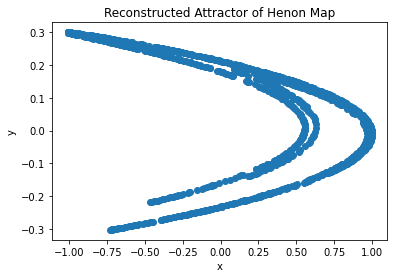

In [9]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach())
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")